In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats     

import pygmsh

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

### The Boussinesq problem or resolution of axissymmetric elasticity

Boussinesq has derived an analytical solution for the stress in a homogeneous medium after axissymmetric loading, interpretable as the loading from a circular foundation of radius $R_f$. We will focus on numerically solving the undrained response. 


We will begin by defining the mesh, where we have more refined elements near the plate's tip. To do so, we will define a custom function for the element size, making use of $\tanh(x)$.

Text(0, 0.5, 'Mesh size')

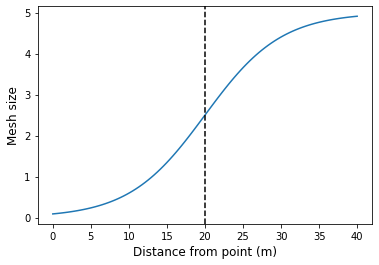

In [72]:
def tanh(dist, max_dist, sharpness, l0, l1, eps=1e-10):
    return  (l1 - l0) * 0.5 * (np.tanh((dist - max_dist)/sharpness) + eps + 1) + l0
    

max_dist = 20
sharpness = 10
min_lc = 0.001
max_lc = 5

d = np.linspace(0, 2 * max_dist, 100)


plt.plot(d, tanh(d, max_dist, sharpness, min_lc, max_lc))
plt.axvline(max_dist, c='k', ls='dashed')
plt.xlabel('Distance from point (m)')
plt.ylabel('Mesh size')

8271


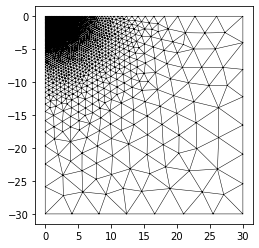

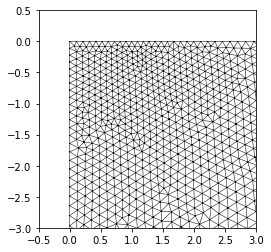

In [73]:
import pygmsh
# we define the mesh
r = 1
refine_radius = 1
R = 30
depth = r * R

with pygmsh.geo.Geometry() as geom:
    box = geom.add_polygon([[0, 0], 
                            [R, 0],
                            [R, -depth],
                            [0, -depth]])

    geom.set_mesh_size_callback(lambda dim, tag, x, y, z, lc : tanh(np.sqrt((x - r)**2 + y**2), max_dist, sharpness, min_lc, max_lc),
                                ignore_other_mesh_sizes=False)

    out = geom.generate_mesh()

mesh = Mesher.Mesh(out, simultype='axis')

mesh.plot()

mesh.plot()
plt.xlim(-0.5, 3)
plt.ylim(-3, 0.5)

# we will try both a constant and linear strain triangle
mesh = Mesher.tri3_2_tri6(mesh)
print(mesh.nn)



In [26]:
"""
from scipy.io import loadmat
import os
matmesh = loadmat('../../mesh.mat')
mesh.nodes = matmesh['nodes']
mesh.connectivity = matmesh['connectivity'] - 1
mesh.nn = len(mesh.nodes)
mesh.ne = len(mesh.connectivity)

mesh.plot()
print(mesh.nn)
"""

"\nfrom scipy.io import loadmat\nimport os\nmatmesh = loadmat('../../mesh.mat')\nmesh.nodes = matmesh['nodes']\nmesh.connectivity = matmesh['connectivity'] - 1\nmesh.nn = len(mesh.nodes)\nmesh.ne = len(mesh.connectivity)\n\nmesh.plot()\nprint(mesh.nn)\n"

../FEM\Element.py:324: RuntimeWarning: divide by zero encountered in true_divide
  DNaDX = DN/j[:, None]


relative difference is -0.16 %


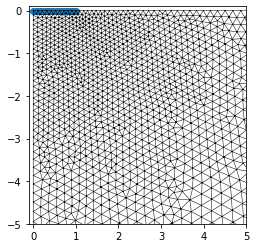

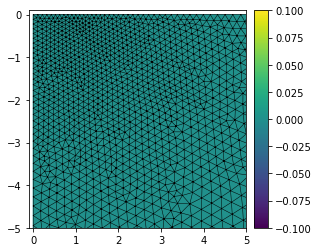

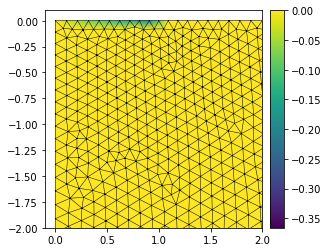

In [74]:
# boundary conditions
traction_boundary = np.argwhere((mesh.nodes[:, 0] <= r) & (mesh.nodes[:, 1] == 0))

mesh.plot()
plt.scatter(*mesh.nodes[traction_boundary].T)
plt.xlim(-0.1, 5)
plt.ylim(-5, 0.1)

# applied load
area = r * r * np.pi
ts = [0, -1]
fs = Matrix.assemble_tractions_over_line(mesh, traction_boundary, ts)
sigma = fs.reshape(2, -1, order='F')

fig, ax, cb = mesh.plot(sigma[0])
ax.set_xlim(-0.1, 5)
ax.set_ylim(-5, 0.1)

fig, ax, cb = mesh.plot(sigma[1])
ax.set_xlim(-0.1, 2)
ax.set_ylim(-2, 0.1)

# the relative difference between the analytiacl applied traction and the numerical should be close to zero
difference = 100 * (fs.sum() - ts[1] * area)/(ts[1] * area)
print(f'relative difference is {difference:.2f} %')


(-1.3, 0.5)

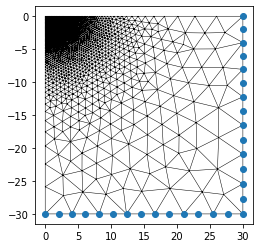

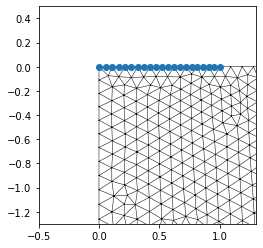

In [75]:
# outer boundaries
bottom = np.argwhere((mesh.nodes[:, 1] == -depth))
right = np.argwhere((mesh.nodes[:, 0] == R))
left = np.argwhere((mesh.nodes[:, 0] == 0))
top = np.argwhere((mesh.nodes[:, 1] == 0))

fixed_nodes = np.unique((bottom, right))
fixed_dof = np.hstack((fixed_nodes, fixed_nodes * 2 + 1))

fig, ax = mesh.plot()

ax.scatter(*mesh.nodes[fixed_nodes].T, zorder=10)
#ax.scatter(*mesh.nodes[traction_boundary].T, zorder=10)

fig, ax = mesh.plot()

ax.scatter(*mesh.nodes[traction_boundary].T, zorder=10)
ax.set_xlim(-0.5, 1.3)
ax.set_ylim(-1.3, 0.5)

In [76]:
E = 20 * 1e6
nu = 0.3

K = Matrix.assemble_stiffness_matrix(mesh, E, nu)

# solving the system
u_set = fixed_dof * 0
eq_to_solve = np.setdiff1d(np.arange(mesh.nn * 2), fixed_dof)
f = -K[eq_to_solve][:, fixed_dof] * u_set + fs[eq_to_solve]

u_aux = linalg.spsolve(K[eq_to_solve][:, eq_to_solve], f)
u_res = np.zeros(mesh.nn * 2)
u_res[eq_to_solve] = u_aux

udisp = u_res.reshape(2, -1, order='F')

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


(-1.0, 0.5)

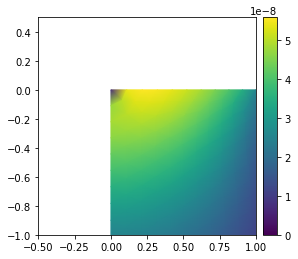

In [86]:
fig, ax, cb = mesh.plot(np.linalg.norm(udisp, axis=0), c='none',)
ax.set_xlim(-0.5, 1)
ax.set_ylim(-1, 0.5)